# Homework 05

## Due Tuesday, March 29th

In [2]:
# importing important things...
from __future__ import print_function   # Python 2/3 compatability

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.basemap import Basemap

import shapely.geometry
import shapely.ops

from scipy import spatial
from scipy import interpolate

### 1. Flyover states

_[This is very similar to the exercise done in class. This is a continuation.]_

What states do you see when you fly from LA (airport code LAX) to NYC (airport code EWR)?

> LAX: 33.9425° N, 118.4081° W

> EWR: 40.6925° N, 74.1686° W

Load in the `states_21basic` shapefile using these commands:

    from mpl_toolkits.basemap import Basemap
    m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
            urcrnrlon=-50.,urcrnrlat=50.,
            rsphere=(6378137.00,6356752.3142),
            resolution='l',projection='merc',
            lat_0=40.,lon_0=-100.,lat_ts=20.)
    m.readshapefile('../materials/states_21basic/states', 'states')

The boundary information for all of the states is now held in an attribute of the map object `m.states`, which is a list of lists of x-y pairs denoting the boundaries. Next use the `m.gcpoints` function to get the points along the great circle path. Convert all of these things into Shapely objects, and check for intersections. Add a buffer of 100km to the flight path to see what states you might potentially see along the way. Use this analysis to provide the following:

1. Create and display a map that shows the flight path, with the states that are seen along the flight path clearly highlighted in some way.

2. Use the information in m.states_info to extract and print a list containing the names of the states seen, with unique names. (see `np.unique`)


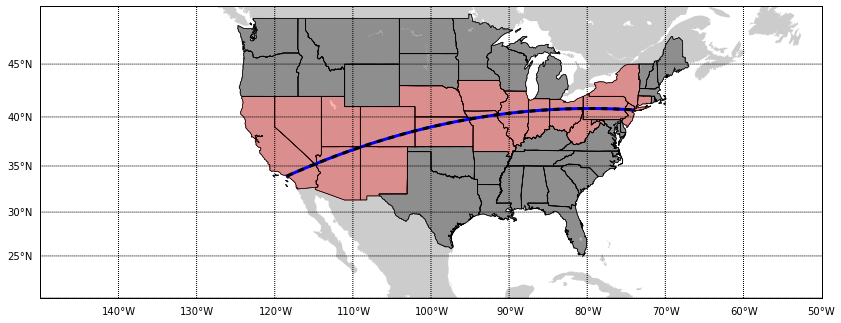

In [37]:
# 1.1
# creating a figure with the U.S. projection with states using Basemap
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(111) 
m = Basemap(llcrnrlon=-150.,llcrnrlat=20.,
        urcrnrlon=-50.,urcrnrlat=50.,
        rsphere=(6378137.00,6356752.3142),
        resolution='l',projection='merc',
        lat_0=40.,lon_0=-100.,lat_ts=20.)
m.readshapefile('../python4geosciences/materials/states_21basic/states', 'states')
m.fillcontinents();
m.set_axes_limits()
m.drawmeridians(np.arange(-140, -40, 10), labels=[0, 0, 0, 1])
m.drawparallels(np.arange(20, 60, 5), labels=[1, 0, 0, 0])

# defining the lat and lon for LAX and EWR 
latLAX = 33.9425
lonLAX = -118.4081
latEWR = 40.6925
lonEWR = -74.1686

# plotting the shortest distance flight path (great circle path) from LAX to EWR
pathx, pathy = m.gcpoints(lonLAX, latLAX, lonEWR, latEWR, 100)
ax.plot(pathx,pathy,linewidth=3)


# creating a for loop to find which states are intersected by the flight path
states = [shapely.geometry.Polygon(xy) for xy in m.states]
line = shapely.geometry.LineString(zip(pathx, pathy))

polys = []

for poly in states:
    if poly.intersects(line.buffer(100000)): # is the distance in meters or degrees?
        color = 'r'      
    else:
        color = 'k'
    plt.plot(*poly.boundary.xy, color='k', lw=0.5)
    plt.fill(*poly.boundary.xy,color=color,alpha=0.3)
    
    
x, y = zip(*line.coords[:])
plt.plot(x, y, '--k', linewidth=3)
plt.gca().set_aspect(1.0)

In [34]:
# 1.2
# Listing the names of States seen during flight
statenames = []
        
for s, poly in enumerate(states):
    if poly.intersects(line.buffer(100000)):
        statenames.append(m.states_info[s]['STATE_NAME'])
        
print('States seen include:\n', np.unique(statenames))

States seen include:
 ['Arizona' 'California' 'Colorado' 'Connecticut' 'Illinois' 'Indiana'
 'Iowa' 'Kansas' 'Missouri' 'Nebraska' 'Nevada' 'New Jersey' 'New Mexico'
 'New York' 'Ohio' 'Pennsylvania' 'Utah' 'West Virginia']


### 2. Area in a Voronoi diagram

Given the series of points:

     np.array([[ 0.77354201,  0.34072038],
               [ 0.43807549,  0.93001924],
               [ 0.5624092 ,  0.79438991],
               [ 0.02536295,  0.46180244],
               [ 0.59533179,  0.07522803],
               [ 0.47867418,  0.70302822],
               [ 0.30371564,  0.83135442],
               [ 0.5856915 ,  0.16340903],
               [ 0.14700491,  0.60268997],
               [ 0.97098631,  0.51692456]])
               
create a Voronoi diagram, and calculate the area contained in the finite regions. What fraction of the total area is at least 0.001 unit away from any boundary? 0.01 away? And 0.1 away?


[[3, 0, -1, 2], [4, 1, 0, 3], [-1, 5, 6, 7], [-1, 0, 1, 5], [], [12, 10, 8, 9, 11], [9, 2, 3, 4, 8], [10, 6, 5, 1, 4, 8], [11, -1, 2, 9], [12, 7, 6, 10], [12, 7, -1, 11]]
area of whole region: 0.288902341571


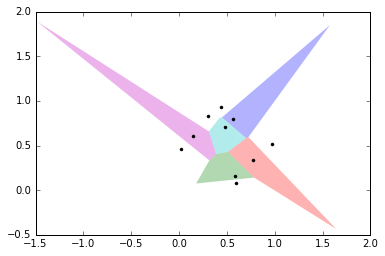

In [49]:
# creating points from given array
pts =  np.array([[ 0.77354201,  0.34072038],
           [ 0.43807549,  0.93001924],
           [ 0.5624092 ,  0.79438991],
           [ 0.02536295,  0.46180244],
           [ 0.59533179,  0.07522803],
           [ 0.47867418,  0.70302822],
           [ 0.30371564,  0.83135442],
           [ 0.5856915 ,  0.16340903],
           [ 0.14700491,  0.60268997],
           [ 0.97098631,  0.51692456]])

# naming Voronoi diagram
vor = spatial.Voronoi(pts)

for indices in vor.regions:
    if not indices: continue     # check for empty regions
    if -1 in indices: continue   # region includes a vertex out of the diagram (the region goes to infinity)
    plt.fill(vor.vertices[indices, 0], vor.vertices[indices, 1], edgecolor='none', alpha=0.3)

# plotting Voronoi diagram
plt.plot(pts[:, 0], pts[:, 1], '.k')

# calculating area of poly regions
def PolygonArea(corners):
    n = len(corners) # of corners
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += corners[i][0] * corners[j][1]
        area -= corners[j][0] * corners[i][1]
    area = abs(area) / 2.0
    return area

# area of whole region
print('area of whole region:', PolygonArea(vor.vertices))
finite_area = PolygonArea(vor.vertices)

# fraction of area at least 0.001 unit away from any boundary

# fraction of area at least 0.01 unit away from any boundary

# fraction of area at least 0.1 unit away from any boundary

In [80]:
# area(vor.regions)
vor.vertices
vor.ridge_vertices?


In [6]:
def area

for i in range(len(vor.regions)):
    region = vor.regions[i]
    if -1 in region:
        continue
    else:
        print(area(vor.regions))

NameError: name 'area' is not defined

### 3. 2D interpolation

Data (found in `python4geosciences/data/MS03_L15.txt`) gathered from a field cruise out of the TAMU Oceanography department is randomly located in space (that is, unstructured) because of the nature of the measurement: the instrument is lowered into the water from a ship, and is brought up and down through the water column as the ship moves to get a sampling of the fields.

Read in the data file and plot the temperature in a `scatter` plot as a function of depth and latitude. Next, interpolate the temperature data to be on a uniform grid (to make it structured). Now, plot it using `contourf`, which requires structured data. Experiment with different spacing in your uniform grid, and with different numbers of contours to see how the results change, and choose values that provide a nice-looking image which closely resembles the original data.

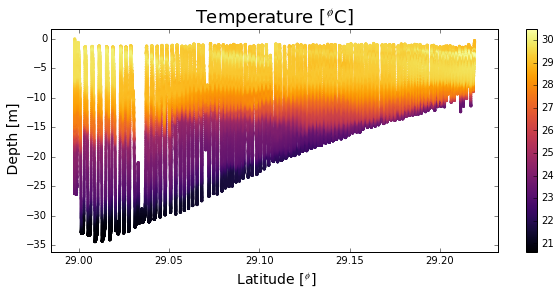

In [3]:
# loading in data file
data = np.loadtxt('..\python4geosciences/data/MS03_L15.txt', comments='*')

# defining values from file
lat = data[:,0]
dep = -data[:,2]
temp = data[:,3]

# creating figure with temperature plotted in color on latitude vs. depth space
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ax.set_title('Temperature [$^\o$C]', fontsize=18)
ax.set_xlabel(' Latitude [$^\o$]',fontsize=14)
ax.set_ylabel(' Depth [m]',fontsize=14)
plot = ax.scatter(lat, dep, s=4, c=temp, cmap='inferno', edgecolors='face')
cbar = plt.colorbar(plot)
ax.axis('tight');

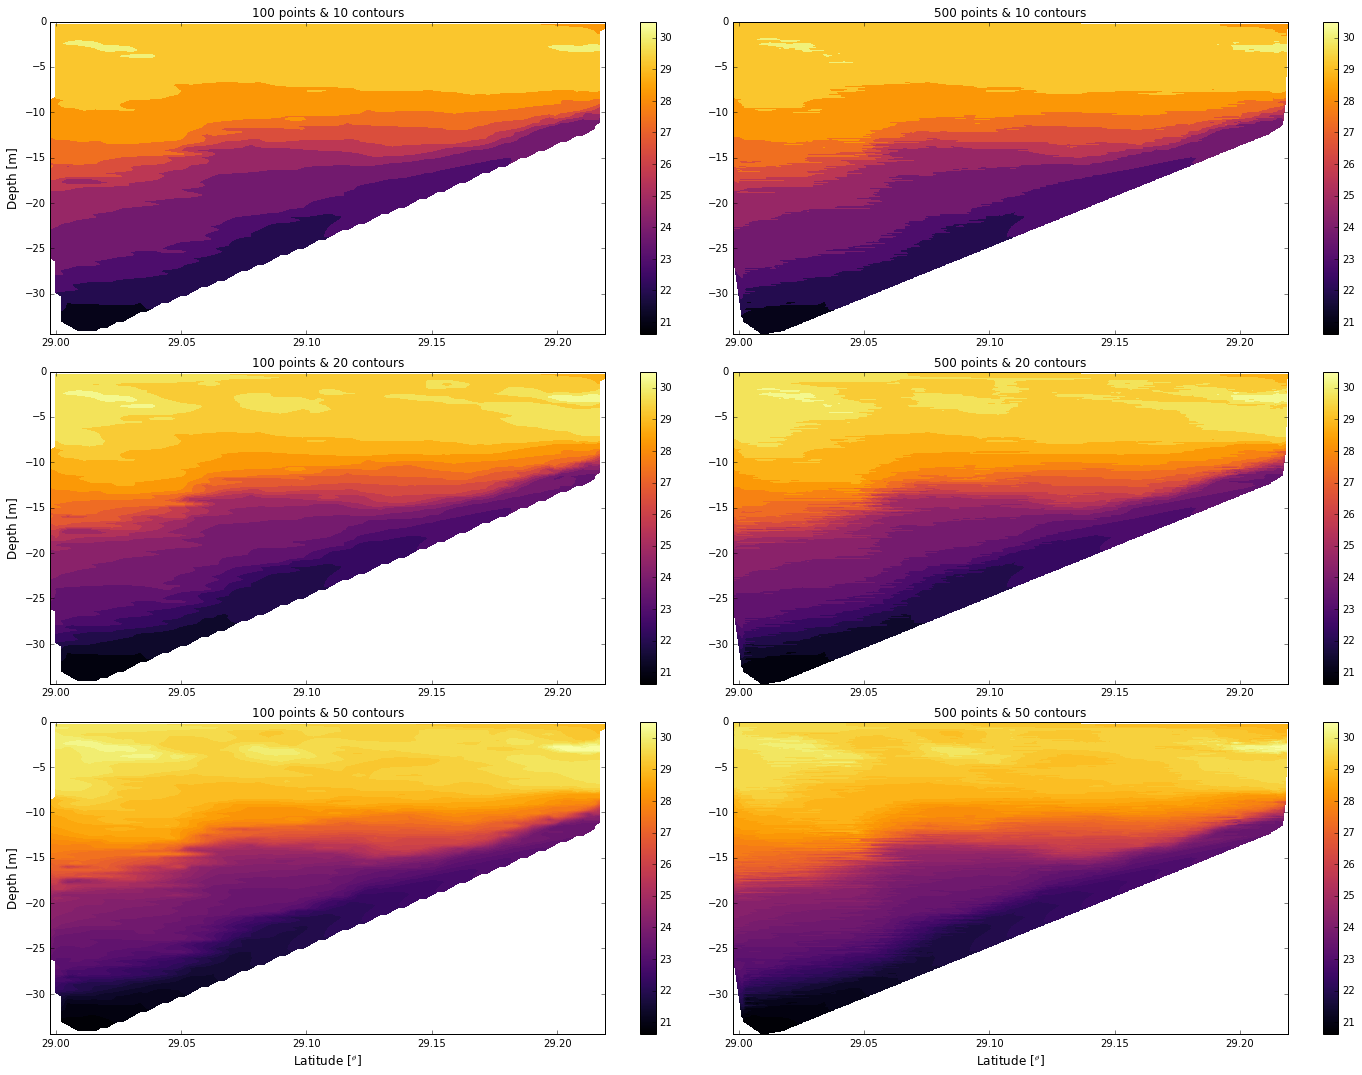

In [7]:
# interpolating the data and playing with contours and number of points

fig = plt.figure(figsize=(20, 15))

tri = spatial.Delaunay(zip(lat, dep))
interp = interpolate.LinearNDInterpolator(tri, temp)

ygrid, xgrid = np.mgrid[min(dep):max(dep):100j, min(lat):max(lat):100j] # from 0 to 1 with 100 points
zgrid = interp(xgrid, ygrid)
zgrid = np.ma.masked_where(np.isnan(zgrid), zgrid) # mask the Nans that are outside the convext hull

# definfing 100 pts
ygrid, xgrid = np.mgrid[min(dep):max(dep):100j, min(lat):max(lat):100j] 
interp = interpolate.LinearNDInterpolator(tri, temp)
zgrid = interp(xgrid, ygrid)

# 10 contours and 100 points
ax2 = fig.add_subplot(321)
ax2.contourf(xgrid,ygrid,zgrid,10,cmap = 'inferno') 
ax2.set_title('100 points & 10 contours')
ax2.set_ylabel('Depth [m]',fontsize=12)
cbar = plt.colorbar(plot)

# 20 contours and 100 points
ax3 = fig.add_subplot(323)
ax3.contourf(xgrid,ygrid,zgrid,20,cmap = 'inferno') 
ax3.set_title('100 points & 20 contours')
ax3.set_ylabel('Depth [m]',fontsize=12)
cbar = plt.colorbar(plot)

# 50 contours and 100 points
ax4 = fig.add_subplot(325)
ax4.contourf(xgrid,ygrid,zgrid,50,cmap = 'inferno') 
ax4.set_title('100 points & 50 contours')
ax4.set_xlabel('Latitude [$^\o$]',fontsize=12)
ax4.set_ylabel('Depth [m]',fontsize=12)
cbar = plt.colorbar(plot)

# definfing 500 pts
ygrid, xgrid = np.mgrid[min(dep):max(dep):500j, min(lat):max(lat):500j] 
interp = interpolate.LinearNDInterpolator(tri, temp)
zgrid = interp(xgrid, ygrid)

# 10 contours and 500 points
ax2 = fig.add_subplot(322)
ax2.contourf(xgrid,ygrid,zgrid,10,cmap = 'inferno') 
ax2.set_title('500 points & 10 contours')
cbar = plt.colorbar(plot)

# 20 contours and 500 points
ax3 = fig.add_subplot(324)
ax3.contourf(xgrid,ygrid,zgrid,20,cmap = 'inferno') 
ax3.set_title('500 points & 20 contours')
cbar = plt.colorbar(plot)

# 50 contours and 500 points
ax4 = fig.add_subplot(326)
ax4.contourf(xgrid,ygrid,zgrid,50,cmap = 'inferno') 
ax4.set_title('500 points & 50 contours')
ax4.set_xlabel('Latitude [$^\o$]',fontsize=12)
cbar = plt.colorbar(plot)

fig.tight_layout()

 When comparing the raw data plot to my contourf plots, I found that the '500 points & 50 contours' plot had the best resolution and resembled the raw data best.

# 4. (Grad) Area of Greenland and Australia in different projections

Set up Basemap instances of the following projections: Mercator, Robinson, and Mollweide; make sure that all three projections are set up to show both Greenland and Australia at the same time (this is necessary for Mercator in particular). Plot them side-by-side to see how they compare.

Next, read in the shape files for Greenland and Australia, found in the `data` directory; you can do this with something like the following (but you might need to change the directory path):

> m.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
> m.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

where `m` is a `Basemap` instance. This gives you a series of polygons that make up each country, saved in `m.greenland` and `m.australia`. Find the area of the two countries in each projection and compare them. What is the area of Australia relative to the area of Greenland for each projection, and how does this compare to what it is in reality?

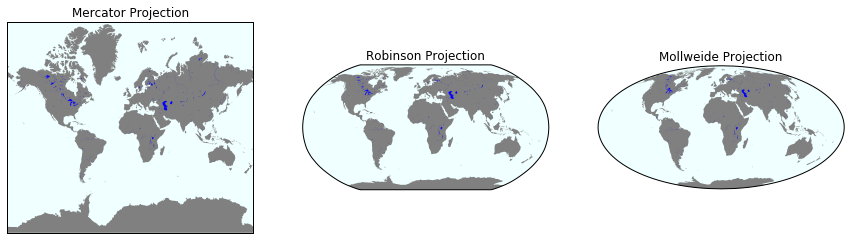

In [9]:
fig = plt.figure(figsize=(15,20))  

ax = fig.add_subplot(131, axis_bgcolor='azure');
ax.set_title('Mercator Projection');                
mmerc = Basemap(projection='merc', llcrnrlat=-80,urcrnrlat=84,llcrnrlon=-180,urcrnrlon=180,resolution='l')# resolution='c')?
mmerc.fillcontinents(color='grey', lake_color='blue');


ax = fig.add_subplot(132, axis_bgcolor='azure');
ax.set_title('Robinson Projection');                 
mrob = Basemap(projection='robin', lon_0 = 10, lat_0 = 50, resolution='l');
mrob.fillcontinents(color='grey', lake_color='blue');


ax = fig.add_subplot(133, axis_bgcolor='azure');
ax.set_title('Mollweide Projection');                 
mmoll = Basemap(projection='moll', lon_0 = 10, lat_0 = 50, resolution='l');
mmoll.fillcontinents(color='grey', lake_color='blue');


In [60]:
mmerc.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
mmerc.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

mrob.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
mrob.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

mmoll.readshapefile('../python4geosciences/data/GRL_adm_shp/GRL_adm0', 'greenland', drawbounds=False)
mmoll.readshapefile('../python4geosciences/data/AUS_adm_shp/AUS_adm0', 'australia', drawbounds=False)

(1,
 5,
 [112.91972351074276, -55.11694335937477, 0.0, 0.0],
 [159.25608825683616, -9.221098899841202, 0.0, 0.0])

In [78]:
# Area of Greenland in Mercator Projection
gland = []
for shape in mmerc.greenland:
        gland.append(shapely.geometry.Polygon(shape))
        
gl_area_merc = []    
for shape in gland:
    gl_area_merc.append(shape.area)
    
# Area of Australia in Mercator Projection
aus = []
for shape in mmerc.australia:
        aus.append(shapely.geometry.Polygon(shape))
        
a_area_merc = []    
for shape in aus:
    a_area_merc.append(shape.area)

# Adding the areas of all the polygons that make up both Greenland Australia
gl_total_merc = sum(gl_area_merc)
a_total_merc = sum(a_area_merc)

print('Mercator area of Greenland:',gl_total_merc)
print('Mercator area of Australia:',a_total_merc)
print('Australia is',(a_total_merc/gl_total_merc)*100,'% of the area of Greenland in Mercator projection')

Mercator area of Greenland: 3.48681546399e+13
Mercator area of Australia: 9.62743077482e+12
Australia is 27.6109558255 % of the area of Greenland in Mercator projection


In [69]:
# Area of Greenland in Robinson Projection
gland = []
for shape in mrob.greenland:
        gland.append(shapely.geometry.Polygon(shape))
gl_area_mrob = []    
for shape in gland:
    gl_area_mrob.append(shape.area)
    
# Area of Australia in Robinson Projection
aus = []
for shape in mrob.australia:
        aus.append(shapely.geometry.Polygon(shape))
a_area_mrob = []    
for shape in aus:
    a_area_mrob.append(shape.area)

# Adding the areas of all the polygons that make up both Greenland Australia
gl_total_mrob = sum(gl_area_mrob)
a_total_mrob = sum(a_area_mrob)

print('Robinson area of Greenland:',sum(gl_area_mrob))
print('Robinson area of Australia:',sum(a_area_mrob))
print('Australia is',(sum(a_area_mrob)/sum(gl_area_mrob))*100,'% of the area of Greenland in Robinson projection')

Robinson area of Greenland: 3.42307733184e+12
Robinson area of Australia: 6.7916905194e+12
Australia is 198.408912829 % of the area of Greenland in Robinson projection


In [68]:
# Area of Greenland in Mollweide Projection
gland = []
for shape in mmoll.greenland:
        gland.append(shapely.geometry.Polygon(shape))
gl_area_moll = []    
for shape in gland:
    gl_area_moll.append(shape.area)
    
# Area of Australia in Mollweide Projection
aus = []
for shape in mmoll.australia:
        aus.append(shapely.geometry.Polygon(shape))
a_area_moll = []    
for shape in aus:
    a_area_moll.append(shape.area)

# Adding the areas of all the polygons that make up both Greenland Australia
gl_total_moll = sum(gl_area_moll)
a_total_moll = sum(a_area_moll)

print('Mollweide area of Greenland:',sum(gl_area_moll))
print('Mollweide area of Australia:',sum(a_area_moll))
print('Australia is',(sum(a_area_moll)/sum(gl_area_moll))*100,'% of the area of Greenland in Mollweide projection')

Mollweide area of Greenland: 2.13444086161e+12
Mollweide area of Australia: 7.69960926922e+12
Australia is 360.731909125 % of the area of Greenland in Mollweide projection


In [65]:
# According to Google...
Aus_sfc_area =  2970000.0 # mi^2
Gland_sfc_area = 836300.0 # mi^2
print('Australia is actually',(Aus_sfc_area/Gland_sfc_area)*100,'% of the area of Greenland')

Australia is actually 355.135716848 % of the area of Greenland


### Actual Surface Areas 

According to Google, Australia is actually 355.135716848 % of the area of Greenland, so the Mollweide projection is the most accurate by far!